In [1]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time, copy
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torcheval.metrics.functional import binary_f1_score

# csv file containing filename and correct label
annotations_file = "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/labels.csv"

# directory containing all images
img_dir = "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/img_dir"

# hyperparameters
batch_size = 64
image_size = 128
nc = 3 # number of channels
nf = 64 # number of features to begin with
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
root = "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset"

In [4]:
# setup transforms and Dataset
transform = transforms.Compose([
                               transforms.Resize(image_size, antialias=True),
                               transforms.CenterCrop(image_size),
                              #  transforms.ToPILImage(),
                              #  transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

class ChestXRayDataset(Dataset):
    def __init__(self, annotations_file, img_dir=img_dir, transform=transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, usecols=['filename','label'])      
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path, mode=ImageReadMode.GRAY).to(torch.float)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            if image.size()[0]==1:
              # some images have three channels, some have one
              # transform.Normalize expects 3 channel image
              image = torch.cat([image]*3, dim=0) 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# setup model
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class XRayClassifier(nn.Module):
    def __init__(self, nc=nc, nf=nf, dropout=dropout):
        super(XRayClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            ResNetBlock(nc,   nf,    stride=2), # (B, C, H, W) -> (B, NF, H/2, W/2), i.e., (64,64,64,64)
            ResNetBlock(nf,   nf*2,  stride=2), # (64,128,32,32)
            ResNetBlock(nf*2, nf*4,  stride=2), # (64,256,16,16)
            ResNetBlock(nf*4, nf*8,  stride=2), # (64,512,8,8)
            ResNetBlock(nf*8, nf*16, stride=2), # (64,1024,4,4)
            nn.Conv2d(nf*16, 1, 4, 1, 0, bias=False),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.pipeline(input.to(device))

In [6]:
# inspect labels
labels_df = pd.read_csv(annotations_file, usecols=['filename','label'])

# split the data into training and testing sets
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# split the training and validation data
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# write files
train_df.to_csv('train_set.csv')
val_df.to_csv('val_set.csv')
test_df.to_csv('test_set.csv')

In [7]:
# Prepare datasets
train_set = ChestXRayDataset('train_set.csv')
val_set = ChestXRayDataset('val_set.csv')
test_set = ChestXRayDataset('test_set.csv')
full_set = ChestXRayDataset(annotations_file)

# Prepare dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_dataloader,
               'val': val_dataloader,
               'test': test_dataloader}

dataset_sizes = {'train': len(train_set),
                 'val': len(val_set),
                 'test': len(test_set)}

In [8]:
dataset_sizes

{'train': 3750, 'val': 938, 'test': 1172}

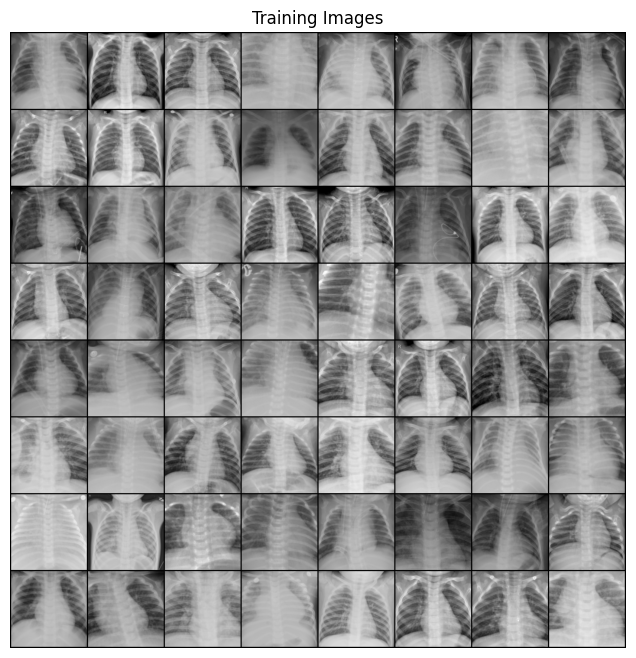

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

batch = next(iter(test_dataloader))

# data visualization
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=5, threshold=0.5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    best_f1 = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
        training_curves[phase+'_f1'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            f1_scores = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    predictions = torch.where(outputs < threshold, 0, 1).view(-1)
                    loss = criterion(outputs.view(-1), labels.to(torch.float))

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                f1_scores += torch.sum(binary_f1_score(outputs.view(-1), labels.detach(), threshold=threshold))
                running_corrects += torch.sum(predictions == labels.detach())
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_scores / (dataset_sizes[phase] / batch_size)
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)       
            training_curves[phase+'_f1'].append(epoch_f1)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_f1 > best_f1:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_f1 = epoch_f1

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch} with F1-score: {best_f1}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [11]:
learning_rate = 0.0001
num_epochs = 20
dropout = 0.2
weight_decay = 0

model = XRayClassifier().to(device)
criterion = nn.BCELoss() # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------
train Loss: 0.4274 Acc: 40.5221 F1: 0.9153
val   Loss: 0.1983 Acc: 36.8209 F1: 0.9602
test  Loss: 0.1941 Acc: 36.7696 F1: 0.9824

Epoch 2/20
----------
train Loss: 0.1876 Acc: 40.4827 F1: 0.9598
val   Loss: 0.1270 Acc: 38.8998 F1: 0.9902
test  Loss: 0.1357 Acc: 38.7133 F1: 1.0005

Epoch 3/20
----------
train Loss: 0.1572 Acc: 40.7643 F1: 0.9661
val   Loss: 0.1396 Acc: 38.7910 F1: 0.9891
test  Loss: 0.1395 Acc: 38.8345 F1: 1.0028

Epoch 4/20
----------
train Loss: 0.1448 Acc: 40.6005 F1: 0.9706
val   Loss: 0.1370 Acc: 38.5928 F1: 0.9837
test  Loss: 0.1422 Acc: 38.4608 F1: 1.0053

Epoch 5/20
----------
train Loss: 0.1352 Acc: 40.6864 F1: 0.9683
val   Loss: 0.1431 Acc: 38.9168 F1: 0.9862
test  Loss: 0.1481 Acc: 38.5870 F1: 1.0037

Epoch 6/20
----------
train Loss: 0.1400 Acc: 40.7541 F1: 0.9684
val   Loss: 0.1444 Acc: 38.4883 F1: 0.9851
test  Loss: 0.1474 Acc: 38.1502 F1: 1.0055

Epoch 7/20
----------
train Loss: 0.1398 Acc: 40.6624 F1: 0.9702
val   Loss: 0.1491 Acc

In [12]:
model_version = '1.0'
models_path = os.path.join(root, 'models', f'chestxray_classifier_v{model_version}')
torch.save(model.state_dict(), models_path)

In [13]:
import sklearn.metrics as metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc', 'f1']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc' or metric == 'f1':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.where(outputs < 0.5, 0, 1).view(-1)
        scores = outputs.view(-1)
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0).view(-1)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


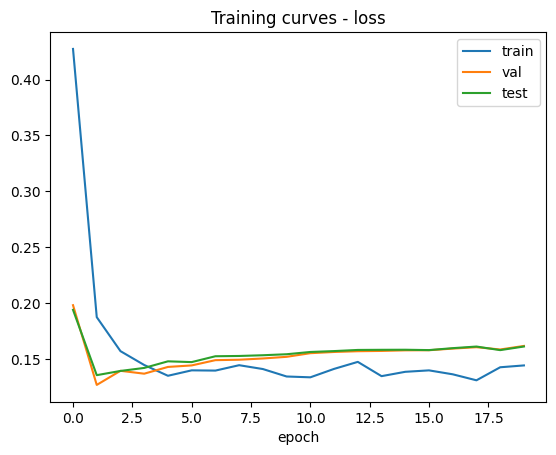

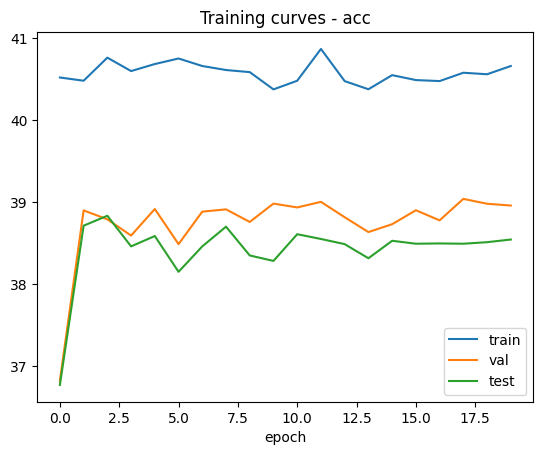

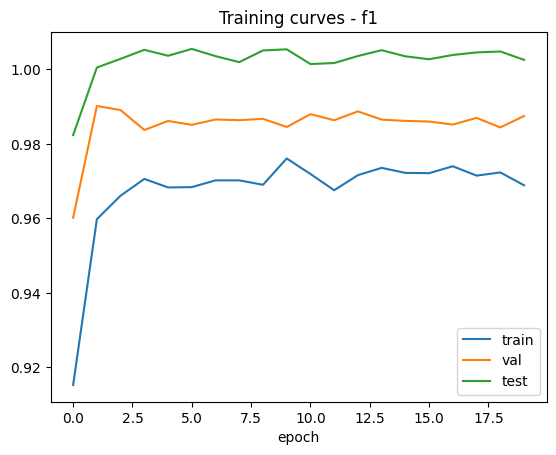

In [14]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

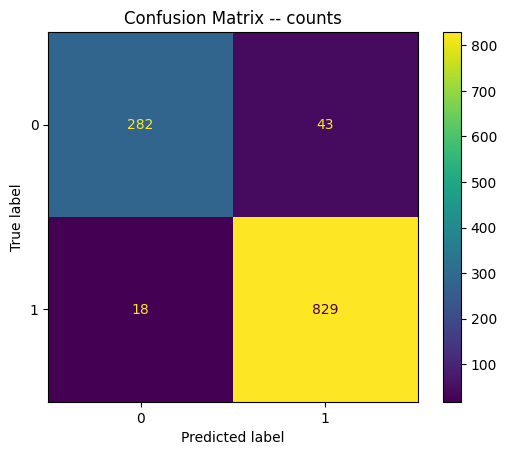

In [15]:
res = plot_cm(model, device, dataloaders, phase='test')